# DS 3000 - Practicum 1

**Student Names**: William Geary, Aryan Jain, Sophie Sawyers

**Date**: 26 May 2024

Note:

- Ensure that all visualizations have a title and label both the x and y axes; all numeric calculations should be rounded to 2 decimal places.
- Use markdown cells to explain your observations about the data.
- Include the names of all teammates on all submissions
- Ensure that your Python code is in a code cell and that it executes without errors.

## Question 1 — The DS Problem (2 points)

1. In your own words, formulate the Data Science problem.

In this practicum, the task involves exploring a subset of flight delay data provided by the Bureau of Transportation Statistics. The goal is twofold:

1. The first part is to understand traffic patterns in Arizona, Nevada, and California. This includes determining the busiest times to travel, the periods with the most delays, and other information associated with the status of flights relative to a certain location. This section of the practicum will allow a consumer to know the best times and locations to travel to based on the lowest number of delays.

2. The second part of the practicum maintains a heavier focus on the individual airlines, but otherwise focuses on similar aspects, such as the time periods with the greatest delays, and the overall ability of an airline to have flights arrive on time. This portion of the practicum will be helpful for a consumer to choose the best airline based on the lowest amounts of delays.

Both sections will allow for a deeper analysis into a very widespread problem: flight delays and how to avoid them. According to Forbes, more than 61% of passengers experienced delayed flights during the summer of 2023, with 54% of those with delayed flights losing more than $\$$200 as a result of the delay. Nearly 1 in 4 people lost more than $\$$500. However, these delays are costly to airports and operators as well, thus, with information available to predict delays, it may be possible to mitigate the financial burden of flight delays for passengers, airports, and airlines simultaneously.

## Question 2 — Prepare the Data (8 pts)

1. Evaluate the dataset to determine if ALL variables are represented in their expected type. Convert variables to suitable data types (if needed).

2. Analyze the data to determine what preprocessing steps are needed. Perform the required data preparation steps. At a minimum, ensure that you handle both missing and invalid values. Justify the approach that is taken to prepare the data for analysis.

3. At a high level explain what the dataset is about and prepare at least three visualizations to support your explanation.

Note: this explanation should be relevant to the DS Problem in question 1.

In [1]:
# Import necessary modules for data analysis, name constant variables
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

FLIGHT_FILE = '2019_ONTIME_REPORTING_FSW.csv' 

In [2]:
# 1. Load the data from the CSV file
flight_df = pd.read_csv(FLIGHT_FILE)

# 1. View the head of the data set
flight_df.head()

,FL_DATE,CARRIER_CODE,TAIL_NUM,FL_NUM,ORIGIN,ORIGIN_ST,DEST,DEST_ST,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,ELAPSED_TIME,DISTANCE
0,2019-10-01,AA,N916NN,2311,TUS,AZ,ORD,IL,828.0,0.0,1353.0,0.0,205.0,1437
1,2019-10-01,AA,N733UW,2315,PHX,AZ,DEN,CO,1907.0,0.0,2159.0,0.0,112.0,602
2,2019-10-01,AA,N140AN,2318,DFW,TX,LAX,CA,1904.0,104.0,2016.0,101.0,192.0,1235
3,2019-10-01,AA,N925AN,2325,SNA,CA,DFW,TX,1729.0,4.0,2215.0,3.0,166.0,1205
4,2019-10-01,AA,N143AN,2328,ATL,GA,LAX,CA,656.0,0.0,841.0,0.0,285.0,1947


In [3]:
# 1. Determine the data types of each column
flight_df.dtypes

FL_DATE          object
CARRIER_CODE     object
TAIL_NUM         object
FL_NUM            int64
ORIGIN           object
ORIGIN_ST        object
DEST             object
DEST_ST          object
DEP_TIME        float64
DEP_DELAY       float64
ARR_TIME        float64
ARR_DELAY       float64
ELAPSED_TIME    float64
DISTANCE          int64
dtype: object

1. The flight date (FL_DATE), departure time (DEP_TIME), and arrival time (ARR_TIME) columns should be a datetime objects. The carrier code (CARRIER_CODE), origin aiport (ORIGIN), origin state (ORIGIN_ST), destination airport (DEST), and destination state (DEST_ST) should be categorical values as there is not much variation, so a normal object datatype is less advantageous. The tail number (TAIL_NUM) should be an object. The flight number (FL_NUM) and distance (DISTANCE) columns should be integers. Finally, the departure delay (DEP_DELAY), arrival delay (ARR_DELAY), and elapsed time (ELAPSED_TIME) should be timedelta objects.

    Therefore, the columns that must be change are FL_DATE, DEP_TIME, ARR_TIME, CARRIER_CODE, ORIGIN, ORIGIN_ST, DEST, DEST_ST, DEP_DELAY, ARR_DELAY, and ELAPSED_TIME. The columns that may remain the same are TAIL_NUM, FL_NUM, and DISTANCE.

In [4]:
def convert_time(date_col, time_col):
    ''' given a column with dates of the format YYYY-MM-DD and a column with times
        of the format HHMM, concatenate the two columns and create a datetime object
        in place of the orginal time column
    '''
    flight_df[time_col] = flight_df[time_col].apply(
        lambda x: str(x).replace('.0', '').zfill(4) if pd.notnull(x) else None).apply(
        lambda x: x[:2] + ':' + x[2:] if pd.notnull(x) else None)

    flight_df[time_col] = flight_df.apply(
        lambda x: x[date_col] + ' ' + x[time_col] if pd.notna(x[time_col]) 
        else None, axis=1)
    
    flight_df[time_col] = flight_df[time_col].astype(str).str.replace('24:','00:')
    
    flight_df[time_col] = pd.to_datetime(flight_df[time_col], errors='coerce')

In [5]:
# 1. Convert the columns to suitable datatypes
# Datetimes
convert_time('FL_DATE', 'DEP_TIME')
convert_time('FL_DATE', 'ARR_TIME')
flight_df['FL_DATE'] = pd.to_datetime(flight_df['FL_DATE'])

# fix the arrival days that were overnight flights
neg_time_diff = flight_df['ARR_TIME'] - flight_df['DEP_TIME'] < pd.Timedelta(0)
flight_df.loc[neg_time_diff, 'ARR_TIME'] = flight_df.loc[
    neg_time_diff, 'ARR_TIME'] + pd.Timedelta(days=1)

# Categorical
categorical_cols = ['CARRIER_CODE', 'ORIGIN', 'ORIGIN_ST', 'DEST', 'DEST_ST']
flight_df[categorical_cols] = flight_df[categorical_cols].astype('category')

# Timedeltas
timedelta_cols = ['DEP_DELAY', 'ARR_DELAY', 'ELAPSED_TIME']
flight_df[timedelta_cols] = flight_df[timedelta_cols].applymap(
    lambda x: timedelta(minutes=x) if pd.notnull(x) else None)

In [6]:
# 2. View information in regards to null values in the dataset
print(flight_df.isna().sum())

FL_DATE             0
CARRIER_CODE        0
TAIL_NUM         4791
FL_NUM              0
ORIGIN              0
ORIGIN_ST           0
DEST                0
DEST_ST             0
DEP_TIME        26707
DEP_DELAY       26715
ARR_TIME        28244
ARR_DELAY       31884
ELAPSED_TIME    31884
DISTANCE            0
dtype: int64


In [7]:
# 2. View the intersection of ARR_DELAY with other NaN columns
print(f"Shape of intersection of NaN values between ARR_DELAY and TAIL_NUM: "
      f"{flight_df[pd.isna(flight_df['ARR_DELAY']) & pd.isna(flight_df['TAIL_NUM'])].shape}")
print(f"Shape of intersection of NaN values between ARR_DELAY and DEP_TIME: "
      f"{flight_df[pd.isna(flight_df['ARR_DELAY']) & pd.isna(flight_df['DEP_TIME'])].shape}")
print(f"Shape of intersection of NaN values between ARR_DELAY and DEP_DELAY: "
      f"{flight_df[pd.isna(flight_df['ARR_DELAY']) & pd.isna(flight_df['DEP_DELAY'])].shape}")
print(f"Shape of intersection of NaN values between ARR_DELAY and ARR_TIME: "
      f"{flight_df[pd.isna(flight_df['ARR_DELAY']) & pd.isna(flight_df['ARR_TIME'])].shape}")
print(f"NaN values in ARR_DELAY are found in the same rows as ELAPSED_TIME: "
      f"{flight_df[pd.isna(flight_df['ARR_DELAY'])].equals(flight_df[pd.isna(flight_df['ELAPSED_TIME'])])}")

Shape of intersection of NaN values between ARR_DELAY and TAIL_NUM: (4791, 14)
Shape of intersection of NaN values between ARR_DELAY and DEP_TIME: (26707, 14)
Shape of intersection of NaN values between ARR_DELAY and DEP_DELAY: (26715, 14)
Shape of intersection of NaN values between ARR_DELAY and ARR_TIME: (28244, 14)
NaN values in ARR_DELAY are found in the same rows as ELAPSED_TIME: True


In [8]:
# 2. Drop the rows with NaN values
flight_df.dropna(inplace=True)

2. There are quite a few missing values, however, as there are nearly 1.9 million entries in the dataset, 30,000 entries equates to only ~1.5% of the total, so the missings values are not terribly widespread. The least number of missing values occurs is the TAIL_NUM column, but because these values are fairly unique, it is impossible to make an educated guess using the mode of the TAIL_NUM column; this would require much more outside work.

    Upon taking a closer look at the intersection of NaN values between rows, it can be concluded that there is a maximum of 31,884 rows that have NaN values. This is to say that the NaN values are not spread out between columns: if there is a NaN value in a column, there will also be an NaN value in ARR_DELAY and ARR_TIME. Thinking about which these columns might have null values, we determine that this is probably caused by flights being cancelled or diverted. 
    
    For the rows in which the flight has taken off or in other words, there exists a value in DEP_TIME, but a null value in ARR_TIME, this might be assumed to be a diverted flight, but we will not make assumptions in this analysis. Furthermore, if there are null values in both the DEP_TIME and ARR_TIME columns, it might be fair to assume that the flight was cancelled, but once more, we will not speculate. Therefore, we will drop the rows with these null values as the rows do not provide sufficient understanding for the departure and arrival status of the aircraft.

3. This dataset contains detailed flight information for domestic flights in 2019 in America, including flight dates, carrier codes, tail numbers, flight numbers, origin and destination airports and states, departure and arrival times, delays, flight durations, and distances. 

    The data can allow us to find anomalies or trends in delays within the aviation industry. For example, the data allows us to see which days have the worst delays, and with the proper context, we can gain insight as to why. We can graph the top 15 and bottom 15 dates based on delay time to see that the total range of total Delay Time by date is over around 140,000 minutes. Furthermore, being able to see the dates with the worst delays might allow one to predict which days will have the worst delays in the future, for example, holidays such as Christmas. 

    The data can also allow us to test some trends. For example, it is obvious that flights with higher departure delays will have higher arrival delays, and we can graph a scatter plot to show this. However, we can also zoom into the cases that do not follow this trend to explore this discrepancy further to discover other causes of flight delays.

    Finally we can explore a large amount of data through the entire country, displaying the total number of flights originating from each state to show air traffic. This will allow for further insights into the best and worst states to travel to based on delays.

    These are just a few ways to explore the data to analyze and gain insights from the structured nature of the millions of flights in America in 2019.

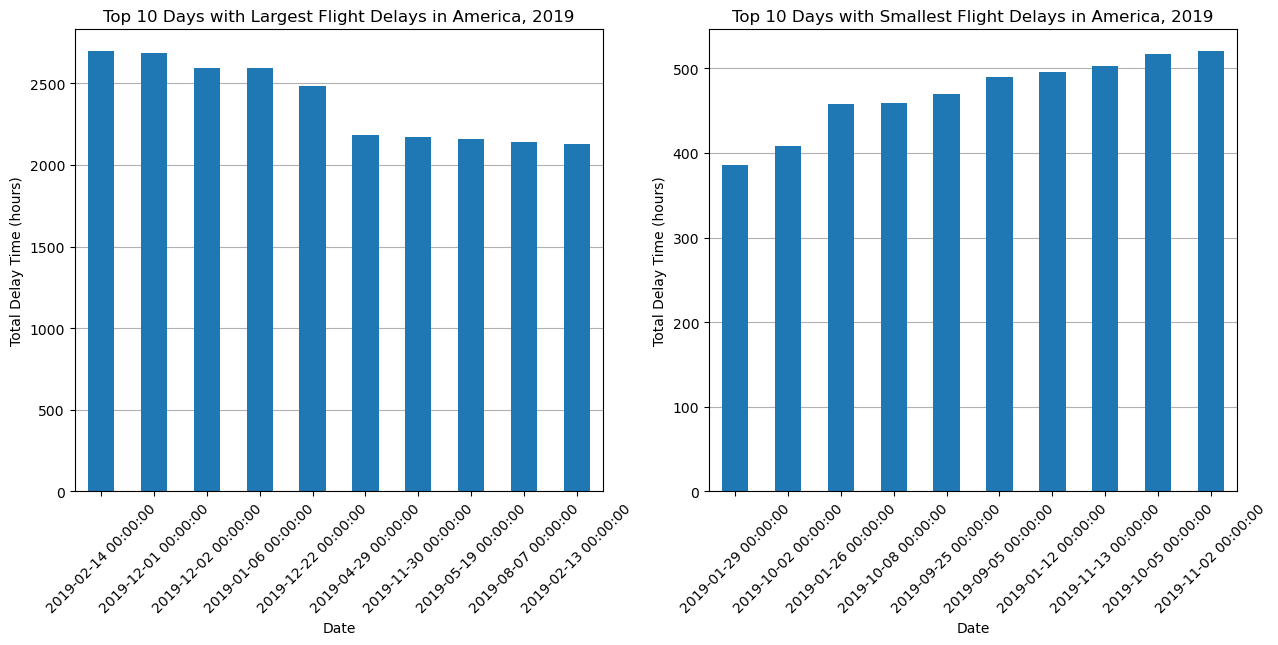

In [9]:
# 3. Exploring departure delay times by date
worst_10 = (flight_df.groupby('FL_DATE')['DEP_DELAY'].sum()
            .sort_values(ascending=False).head(10))
best_10 = (flight_df.groupby('FL_DATE')['DEP_DELAY'].sum()
           .sort_values().head(10))

# plot the worst 10 days
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
ax = (((worst_10 / pd.Timedelta(1, 'h')).head(10))
      .plot(kind='bar', title='Top 10 Days with Largest Flight Delays in America, 2019',
            xlabel='Date', ylabel='Total Delay Time (hours)', rot=45, zorder=2))
plt.grid(axis='y')

# plot the 10 best days
plt.subplot(1, 2, 2)
(((best_10 / pd.Timedelta(1, 'h')).head(10))
 .plot(kind='bar', title='Top 10 Days with Smallest Flight Delays in America, 2019',
       xlabel='Date', ylabel='Total Delay Time (hours)', rot=45, zorder=2))

plt.grid(axis='y')

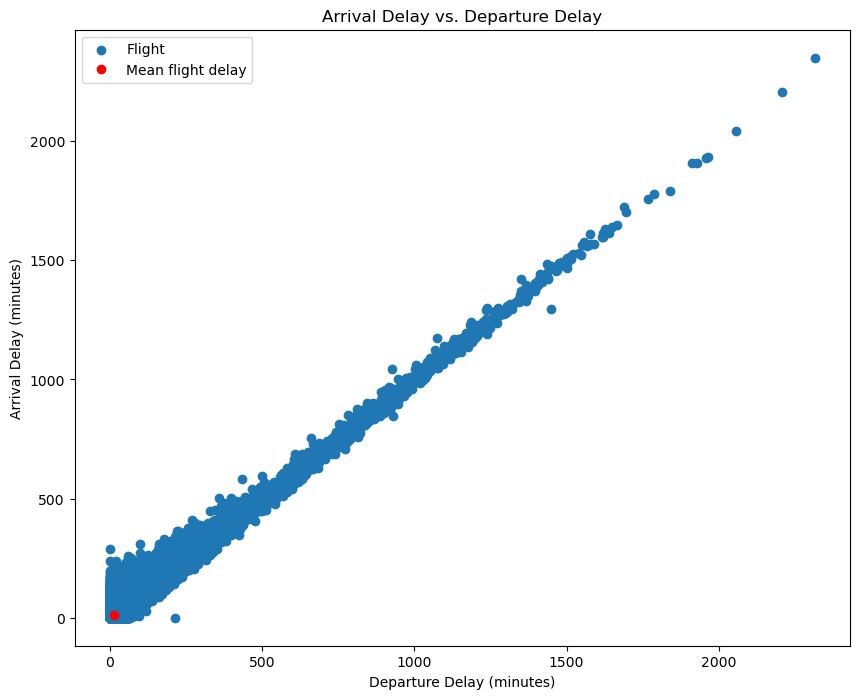

In [10]:
# 3. Exploring departure delay vs arrival delay
plt.figure(figsize=(10, 8))
plt.scatter(flight_df['DEP_DELAY'] / pd.Timedelta(1, 'm'), 
            flight_df['ARR_DELAY'] / pd.Timedelta(1, 'm'),
            label='Flight')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Arrival Delay (minutes)')
plt.title('Arrival Delay vs. Departure Delay')
plt.plot(flight_df['DEP_DELAY'].mean() / pd.Timedelta(1, 'm'), 
         flight_df['ARR_DELAY'].mean() / pd.Timedelta(1, 'm'), 'or', zorder=1,
         label='Mean flight delay')
plt.legend()
plt.show()

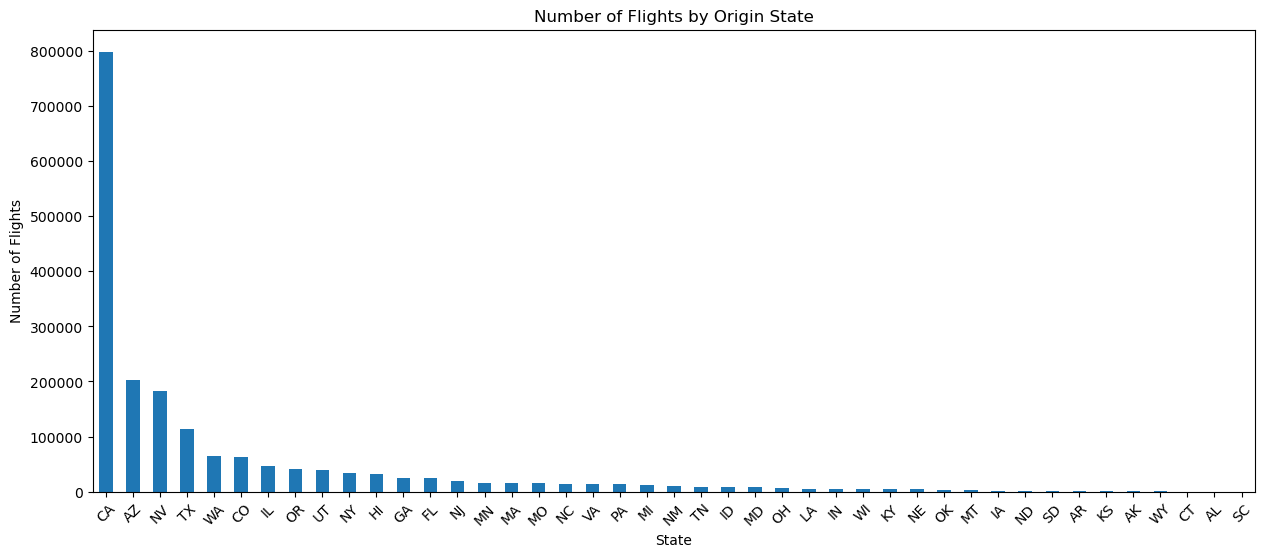

In [11]:
# 3. Exploring states with most flight departures
plt.figure(figsize=(15, 6))
flight_df['ORIGIN_ST'].value_counts().plot(kind='bar')
plt.xlabel('State')
plt.ylabel('Number of Flights')
plt.title('Number of Flights by Origin State')
plt.xticks(rotation=45)
plt.show()

## Question 3 — (20 points)

1. Explore patterns in the region i.e. the 3 states (AZ, NV, CA). Determine which region has the most air traffic. Comment on your findings and visualize the results.

2. For each region, analyze the most popular outbound/destination airports. For example, if a flight originated in CA (at any of its airports), where do they often go? Comment on your findings and visualize the top 5 results.

ORIGIN_ST
CA    798690
AZ    201804
NV    181985
dtype: int64


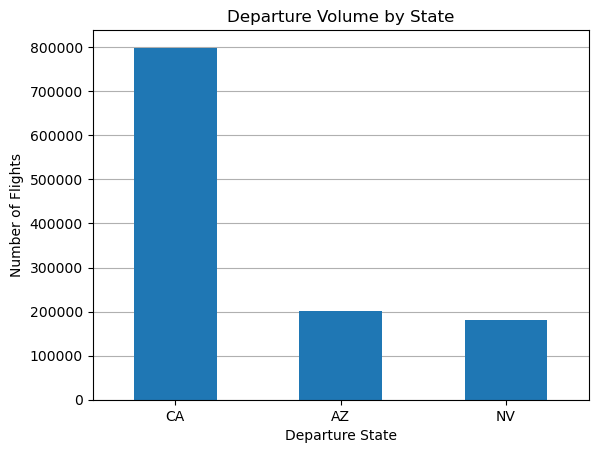

In [12]:
# 1. Compare the number of flights in each of the three regions
print(flight_df.groupby('ORIGIN_ST').size()[['AZ', 'CA', 'NV']].sort_values(
    ascending=False))
flight_df.groupby('ORIGIN_ST').size()[['AZ', 'CA', 'NV']].sort_values(
    ascending=False).plot(kind='bar', title='Departure Volume by State',
                         xlabel='Departure State', ylabel='Number of Flights',
                         rot=0, zorder=2)
plt.grid(axis='y')

1. For flight departures, California has the most air traffic of the three regions. With almost 800,000 flights, CA has nearly 4 times the flight volume of Arizona, and roughly 4.5 times that of Nevada.

In [13]:
def plot_dep_vol(group_1, group_2, state, fl_type, head=5):
    ''' given a column name for the first grouping, either ORIGIN_ST or DEST_ST,
        a column name for the second grouping, either ORIGIN or DEST, a state 
        abbreviation, and a flight type, either Departure or Arrival, 
        print the exact number of flights and plot the values
    '''
    print(flight_df.groupby([group_1, group_2]).size().loc[state].sort_values(
        ascending=False).head(head))
    flight_df.groupby([group_1, group_2]).size().loc[state].sort_values(
        ascending=False).head(head).plot(kind='bar', 
                                     title=f"{state} Departure Volume by {fl_type} Airport",
                                     xlabel=f"{fl_type} Airport", ylabel=f"Number of {fl_type}s",
                                     rot=0, zorder=2)
    plt.grid(axis='y', which='major', zorder=1)

ORIGIN
LAX    216481
SFO    166750
SAN     91734
SJC     61681
OAK     51962
dtype: int64
DEST
PHX    48997
LAS    48239
SFO    43958
SEA    43233
LAX    40025
dtype: int64


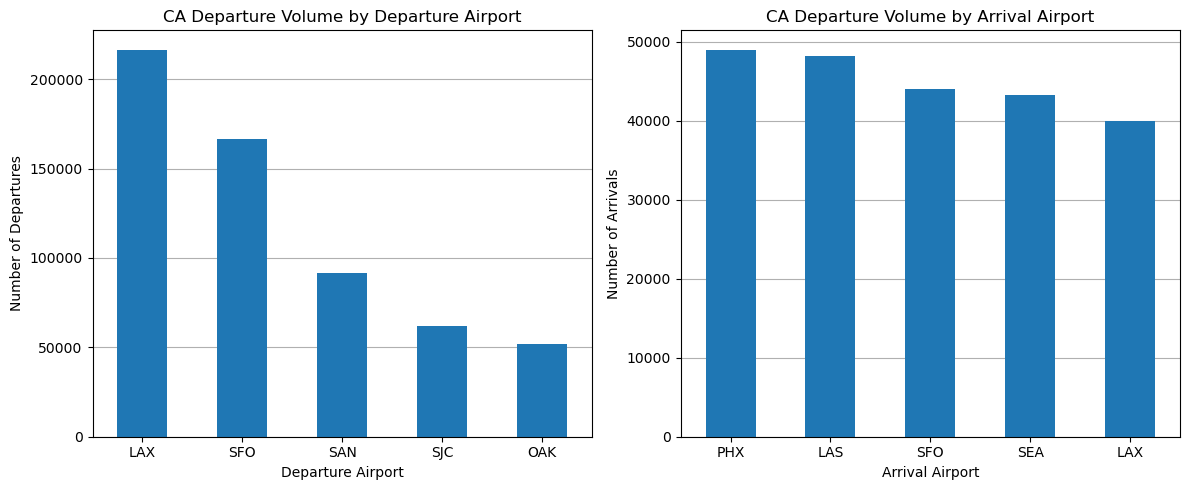

In [14]:
# 2. Take a closer look at departures and arrivals from CA based airports
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_dep_vol('ORIGIN_ST', 'ORIGIN', 'CA', 'Departure')

plt.subplot(1, 2, 2)
plot_dep_vol('ORIGIN_ST', 'DEST', 'CA', 'Arrival')
plt.tight_layout()

ORIGIN
PHX    172578
TUS     18993
AZA      5665
FLG      1935
YUM      1909
dtype: int64
DEST
DEN    10197
LAX     9585
DFW     7692
SEA     6836
LAS     6730
dtype: int64


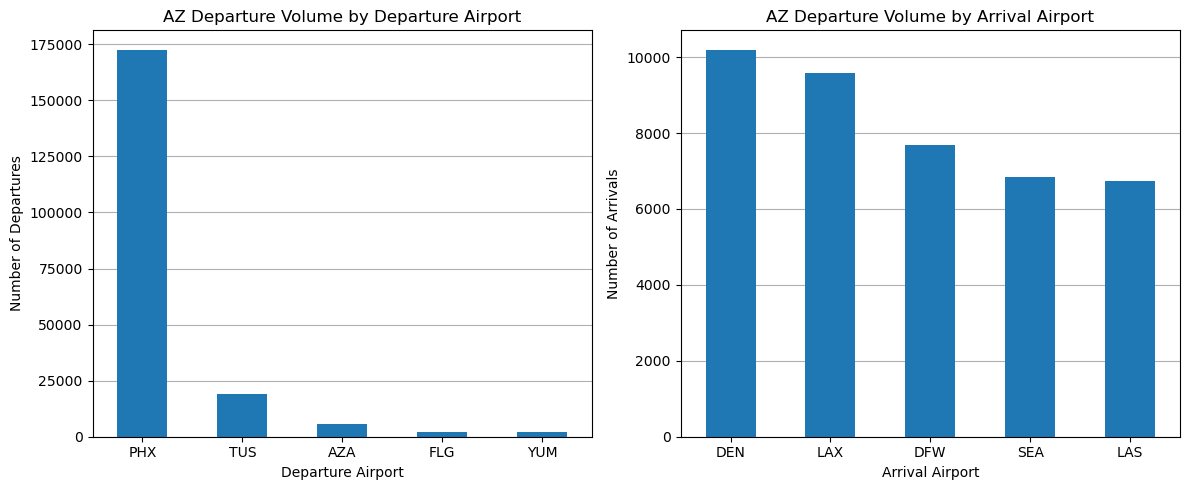

In [15]:
# 2. Take a closer look at departures and arrivals from AZ based airports
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_dep_vol('ORIGIN_ST', 'ORIGIN', 'AZ', 'Departure')

plt.subplot(1, 2, 2)
plot_dep_vol('ORIGIN_ST', 'DEST', 'AZ', 'Arrival')
plt.tight_layout()

ORIGIN
LAS    161620
RNO     19695
EKO       670
dtype: int64
DEST
LAX    13834
SFO     9233
DEN     8605
PHX     7755
SEA     7164
dtype: int64


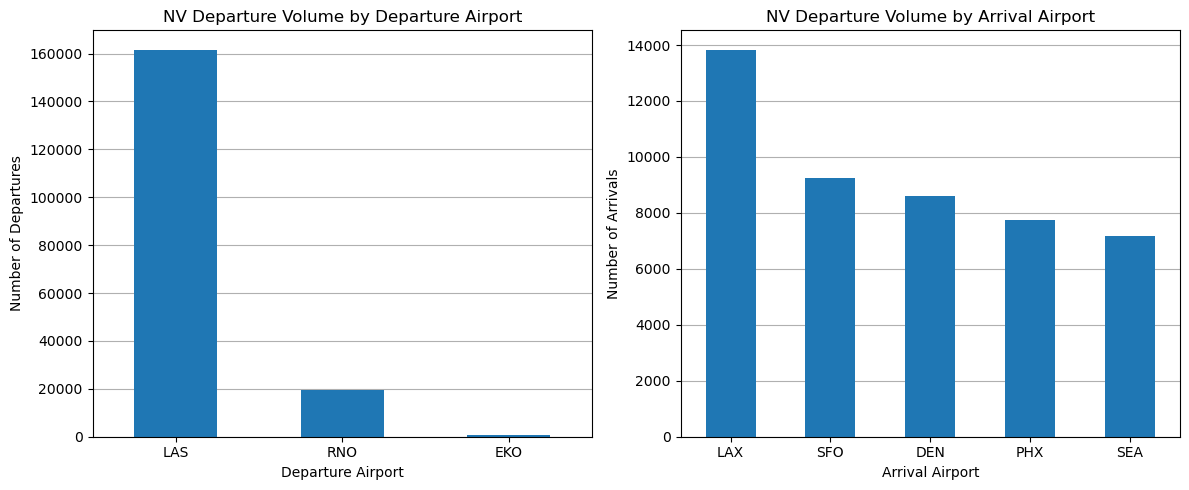

In [16]:
# 2. Take a closer look at departures and arrivals from NV based airports
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_dep_vol('ORIGIN_ST', 'ORIGIN', 'NV', 'Departure', 3)

plt.subplot(1, 2, 2)
plot_dep_vol('ORIGIN_ST', 'DEST', 'NV', 'Arrival')
plt.tight_layout()

In [17]:
# 2. View the total number of flights departing and arriving from airports
print(flight_df['ORIGIN'].value_counts().head())
print(flight_df['DEST'].value_counts().head())

LAX    216481
PHX    172578
SFO    166750
LAS    161620
SAN     91734
Name: ORIGIN, dtype: int64
LAX    216677
PHX    172460
SFO    166834
LAS    161725
SAN     91796
Name: DEST, dtype: int64


2. California: Los Angeles (LAX) was the most common departure airport with around 216,000 departing flights. This was about 30% more flights than the second most common departure airport in California, San Francisco (SFO). The third most common departure airport was San Diego (SAN). For arrivals of flights departing from California, Phoenix (PHX) was the most common airport, with around 50,000 arriving flights. Las Vegas (LAS) and San Francisco (SFO) were close second and third. Seattle-Tacoma (SEA) was forth, and Los Angeles (LAX) also made the arrival list in fifth place, with 40,025 arriving flights.

    Arizona: The most common departure airport in Arizona was Phoenix Sky Harbor (PHX). With 172,578 departing flights in 2019, PHX had about 9 times the flight departure volume of the second most common Arizona airport, Tucson (TUS). As for the arrivals, for flights departing from Arizona, no additional AZ airport made the most common arrival list. Instead, Denver (DEN) led the arrivals from Arizona with 10,197 flights, and LAX was a close second with around 9,600. Dallas (DFW) was third, and Seattle-Tacoma (SEA) and Las Vegas (LAS) were nearly tied for fourth and fifth, with around 6,800 arriving flights each.
    
    Nevada: Nevada only had three departing airports in this dataset, the most common being Las Vegas (LAS), with 161,620 departing flights in 2019. The second most common departure airport was Reno (RNO) with about 20,000 departing flights, and Elko Regional Airport (ELK), with less than 1,000. As for arriving flights that departed from Nevada, the most common airport was Los Angeles (LAX) with 13,834 flights, while San Francisco (SFO), Denver (DEN), Phoenix (PHX), and Seattle-Tacoma (SEA) ranged from 9,200 to 7,100 respectively. 
    
    In this initial analysis of the data, a few airports stick out as some of the most common. These include LAX and SFO for California, PHX for Arizona, LAS for Nevada, SEA for Washington, as well as DEN for Colorado. Most of these values are confirmed by applying a value count to the departing and arriving flights. SAN remains in the list as well as California has many more flights than Arizona and Nevada.

## Question 4 — (20 points)

1. Explore the carriers. Calculate the **proportion** of flights for each airline/operator. Visualize the top 10 results. Explain the results.

2. Analyze the flight delays for each Airline/Carrier and prepare summary statistics to explain the patterns in the delays. Visualize the results. Explain the patterns and demonstrate which carriers are more prone to flight delays.

Note: you will need to analyze the airlines/carriers across multiple airports in order to conclude that they have a pattern of being late.

CARRIER_CODE
WN    29.15
AA    15.07
UA    12.54
OO    12.53
DL    10.05
AS     7.89
B6     3.04
NK     2.88
YV     2.22
F9     1.87
dtype: float64


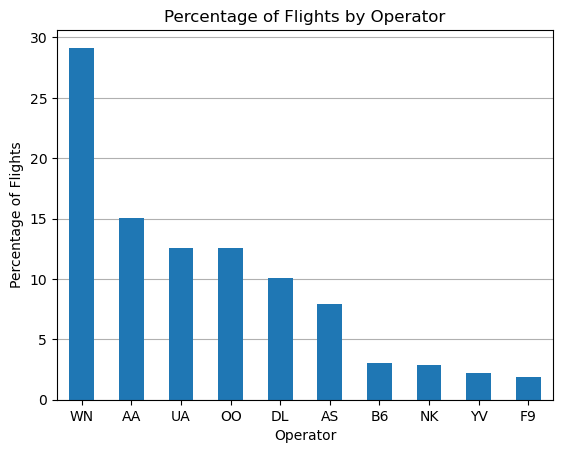

In [18]:
# 1. Calculate the proportion of flights for each operator
operator_props = (flight_df.groupby('CARRIER_CODE').size().sort_values(
    ascending=False) * 100 / flight_df.shape[0])
print(round(operator_props[:10], 2))

# plot the proportions for the top 10 operators
operator_props[:10].plot(kind='bar',title='Percentage of Flights by Operator', 
                         xlabel='Operator', ylabel='Percentage of Flights', rot=0,
                         zorder=2)
plt.grid(axis='y')

1. There is a clear airline which conducts the majority of flights to and from California, Arizona, and Nevada: Southwest Airlines (WN). Southwest made up 29.15% of all flights to and from these three regions in 2019, nearly doubling the number of flights by second-place operator American Airlines (AA), which made up 15.07% of all flights. Note that United Airlines (UA) was in third place with 12.54%, followed closely by SkyWest Airlines (OO), which consisted of 12.53% of all flights. Note that SkyWest operates regional flights for American Eagle, Delta Connection, United Express, and Alaska Airlines, so, if looking at airlines, this might slightly increase their respective percentages. Delta Air Lines (DL) was fifth with 10.05%, followed by Alaska Airlines (AS) with 7.89%. JetBlue Airways (B6), Spirit Airlines (NK), Mesa Airlines (YV), which operates on behalf of United Express, and Frontier Airlines (F9) all had flight percentages under 3.05%. 

    While American Airlines, United Airlines, Delta Air Lines, and JetBlue Airways are still considered some of the larger airlines in the United States, they are not the main carriers in the West, or at least not in the three regions in this dataset. This title is taken by Southwest.

In [19]:
# 2. Create a variable with the top ten carrriers
top_10 = flight_df.groupby('CARRIER_CODE').size().sort_values(ascending=False).head(10).index

Average Departure Delay by Operator
CARRIER_CODE
F9   0 days 00:19:59
YX   0 days 00:18:38
B6   0 days 00:16:28
UA   0 days 00:15:25
YV   0 days 00:15:24
AA   0 days 00:14:37
OO   0 days 00:14:25
G4   0 days 00:13:10
NK   0 days 00:13:02
EV   0 days 00:11:38
WN   0 days 00:11:21
MQ   0 days 00:11:07
HA   0 days 00:11:02
DL   0 days 00:10:48
AS   0 days 00:10:43
Name: DEP_DELAY, dtype: timedelta64[ns]


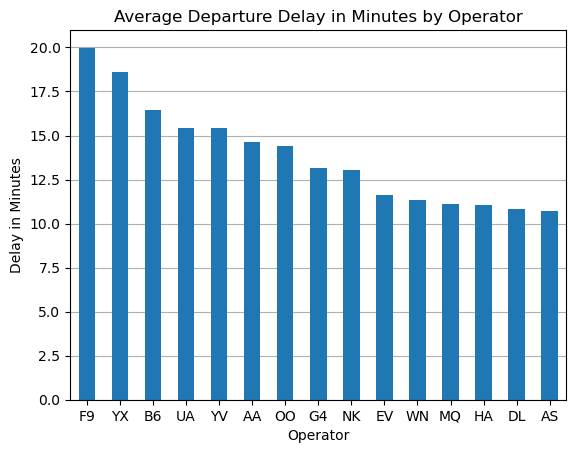

In [20]:
# 2. Determine the average departure delays per airline
dep_delay_avgs = (flight_df.groupby('CARRIER_CODE')['DEP_DELAY'].mean()
                  .dt.round('s').sort_values(ascending=False))
print(f"Average Departure Delay by Operator\n{dep_delay_avgs}")

# Plot the results
((dep_delay_avgs / pd.Timedelta(1, 'm')).sort_values(ascending=False)
 .plot(kind='bar', title='Average Departure Delay in Minutes by Operator',
       xlabel='Operator', ylabel='Delay in Minutes', rot=0, zorder=2))

plt.grid(axis='y')

2. Compared to the prior question, there are some changes in regard to the top 10 worst operators by average departure delay. Now, Frontier Airlines (F9) has taken the first position, with an average departure delay of almost 20 minutes, followed by Republic Airways (YX), whose average departure delay is about 18.5 minutes. JetBlue Airways (B6) was third with an average delay of 16:28. As for the three operators with the shortest average departure delays, Hawaiian (HA) was the third best, with an average departure delay of 11:02, Delta Air Lines (DL) was second, with an average of 10:48, and Alaska Airlines (AS) was the operator with the shortest average departure delay, 10:43. 

Average Arrival Delay by Operator
CARRIER_CODE
F9   0 days 00:19:00
YX   0 days 00:18:22
B6   0 days 00:16:03
UA   0 days 00:15:42
YV   0 days 00:15:31
AA   0 days 00:14:40
OO   0 days 00:14:34
G4   0 days 00:13:49
EV   0 days 00:13:15
HA   0 days 00:12:57
NK   0 days 00:12:43
AS   0 days 00:11:55
MQ   0 days 00:10:34
DL   0 days 00:10:30
WN   0 days 00:09:36
Name: ARR_DELAY, dtype: timedelta64[ns]


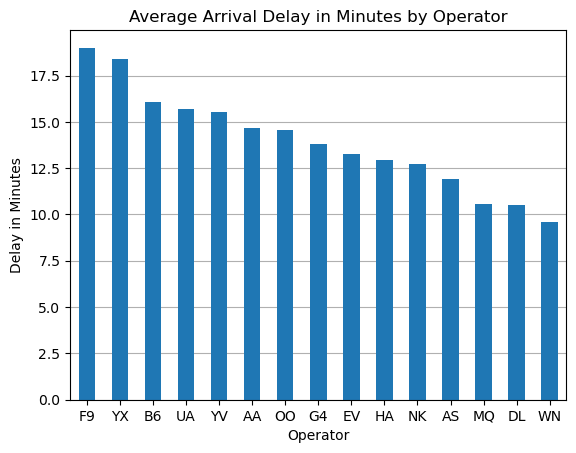

In [21]:
# 2. Determine the average arrival delays per airline
arr_delay_avgs = (flight_df.groupby('CARRIER_CODE')['ARR_DELAY'].mean()
                  .dt.round('s').sort_values(ascending=False))
print(f"Average Arrival Delay by Operator\n{arr_delay_avgs}")

# Plot the results
((arr_delay_avgs / pd.Timedelta(1, 'm')).sort_values(ascending=False)
 .plot(kind='bar', title='Average Arrival Delay in Minutes by Operator',
       xlabel='Operator', ylabel='Delay in Minutes', rot=0, zorder=2))

plt.grid(axis='y')

2. Taking a look at the operators with the worst average arrival delays, Frontier Airlines (F9) remains the operator with the worst record, with an average of 19:00 minutes. Republic Airways (YX) and JetBlue Airways (B6) once more follow in order, with average arrival delays of 18:22 and 16:03 respectively. The operators with the lowest average arrival delays are Envoy Air (MQ), with an average of 10:34, Delta Air Lines (DL) with 10:30, and Southwest Airlines, with an average arrival delay of 9:36 minutes.


Departure Delay Percentages for All Carriers
 CARRIER_CODE
HA    48.04
WN    47.99
F9    43.26
AA    39.21
MQ    35.25
DL    35.16
B6    34.17
UA    33.60
G4    32.53
AS    32.11
NK    30.51
YV    29.15
EV    26.60
OO    25.60
YX    25.32
dtype: float64


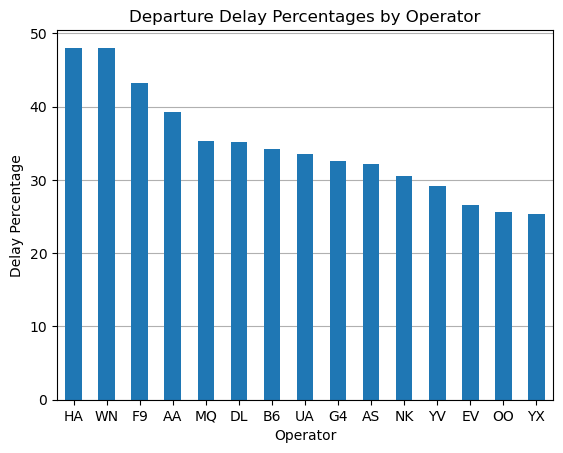

In [22]:
# 2. Determine the percentage of departure delays by airline
dep_delay_pcts = (100 * flight_df[flight_df['DEP_DELAY'] > pd.Timedelta(0)]
    .groupby('CARRIER_CODE').size() / flight_df.groupby('CARRIER_CODE').size())

print(f"\nDeparture Delay Percentages for All Carriers\n "
      f"{round(dep_delay_pcts, 2).sort_values(ascending=False)}")

# Plot the results of the departure delay percentages
(dep_delay_pcts.sort_values(ascending=False)
 .plot(kind='bar', title='Departure Delay Percentages by Operator',
       xlabel='Operator', ylabel='Delay Percentage', rot=0, zorder=2))
plt.grid(axis='y')


Arrival Delay Percentages for All Carriers
 CARRIER_CODE
HA    50.33
F9    42.02
G4    38.47
AA    38.00
AS    37.40
UA    35.43
WN    35.07
MQ    34.63
YV    34.56
B6    33.26
DL    31.92
NK    31.86
EV    30.85
OO    30.30
YX    27.27
dtype: float64


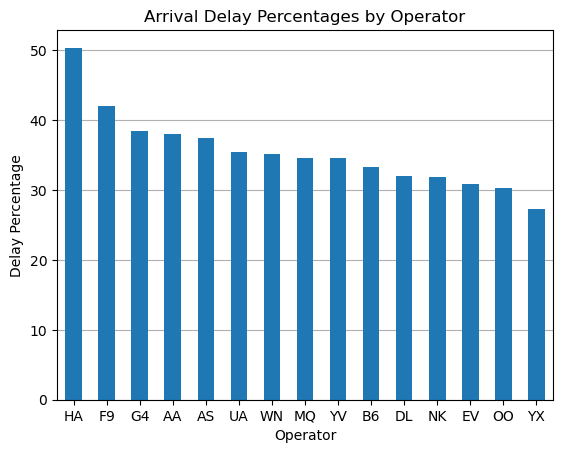

In [23]:
# 2. Determine the percentage of arrival delays by airline
arr_delay_pcts = (100 * flight_df[flight_df['ARR_DELAY'] > pd.Timedelta(0)]
    .groupby('CARRIER_CODE').size() / flight_df.groupby('CARRIER_CODE').size())

print(f"\nArrival Delay Percentages for All Carriers\n "
      f"{round(arr_delay_pcts, 2).sort_values(ascending=False)}")

# Plot the results of the arrival delay percentages
(arr_delay_pcts.sort_values(ascending=False)
 .plot(kind='bar', title='Arrival Delay Percentages by Operator',
       xlabel='Operator', ylabel='Delay Percentage', rot=0, zorder=2))
plt.grid(axis='y')

2. Between the two plots of the percentages of delayed departures and arrivals by operator, it is interesting to notice that while Hawaiian Airlines (HA) has some of the lowest average departure and arrival delays, they consistently have the greatest percentage of delayed departures and arrivals (48.04% and 50.33% respectively). On the other end of the spectrum, it is interesting to notice that Republic Airways (YX) has some of the greatest average departure and arrival delays, but they have the smallest percentage of departure and arrival delays (25.32% and 27.27% respectively).

    Meanwhile, Frontier (F9) seems to have both large average delays and a large percentage of delayed flights (43.26% of departures and 42.02% of arrivals). Another interesting takeaway is that Southwest Airlines (WN) has one of the worst departure delay percentages (47.99%), but their arrival delay percentage falls around average (35.07%). Otherwise, the majority of operators seem to have delay percentages that fall in the range of 30-40 percent, with the exception of Mesa Airlines (YV), ExpressJet (EV), and SkyWest Airlines (OO), whose departure delay percentages also fall in the high 20s.

In [24]:
# 2. Determine the percentage of departure delays by airline
orig_dep_delays = (round(flight_df[flight_df['DEP_DELAY'] > pd.Timedelta(0)]
                   .groupby(['ORIGIN', 'CARRIER_CODE']).size() * 100
                   / flight_df.groupby(['ORIGIN', 'CARRIER_CODE']).size(), 2))

# clean the values to remove nulls, sort values by airport
orig_dep_delays = (orig_dep_delays[orig_dep_delays.notnull()]
                   .reset_index(name='DELAY_PROP')
                   .sort_values(by=['ORIGIN', 'DELAY_PROP'], 
                                ascending=[True, False]))

In [25]:
# 2. Determine the percentage of arrival delays by airline
dest_arr_delays = (round(flight_df[flight_df['ARR_DELAY'] > pd.Timedelta(0)]
                   .groupby(['DEST', 'CARRIER_CODE']).size() * 100
                   / flight_df.groupby(['DEST', 'CARRIER_CODE']).size(), 2))

# clean the values to remove nulls, sort values by airport
dest_arr_delays = (dest_arr_delays[dest_arr_delays.notnull()]
                   .reset_index(name='DELAY_PROP')
                   .sort_values(by=['DEST', 'DELAY_PROP'], 
                                ascending=[True, False]))

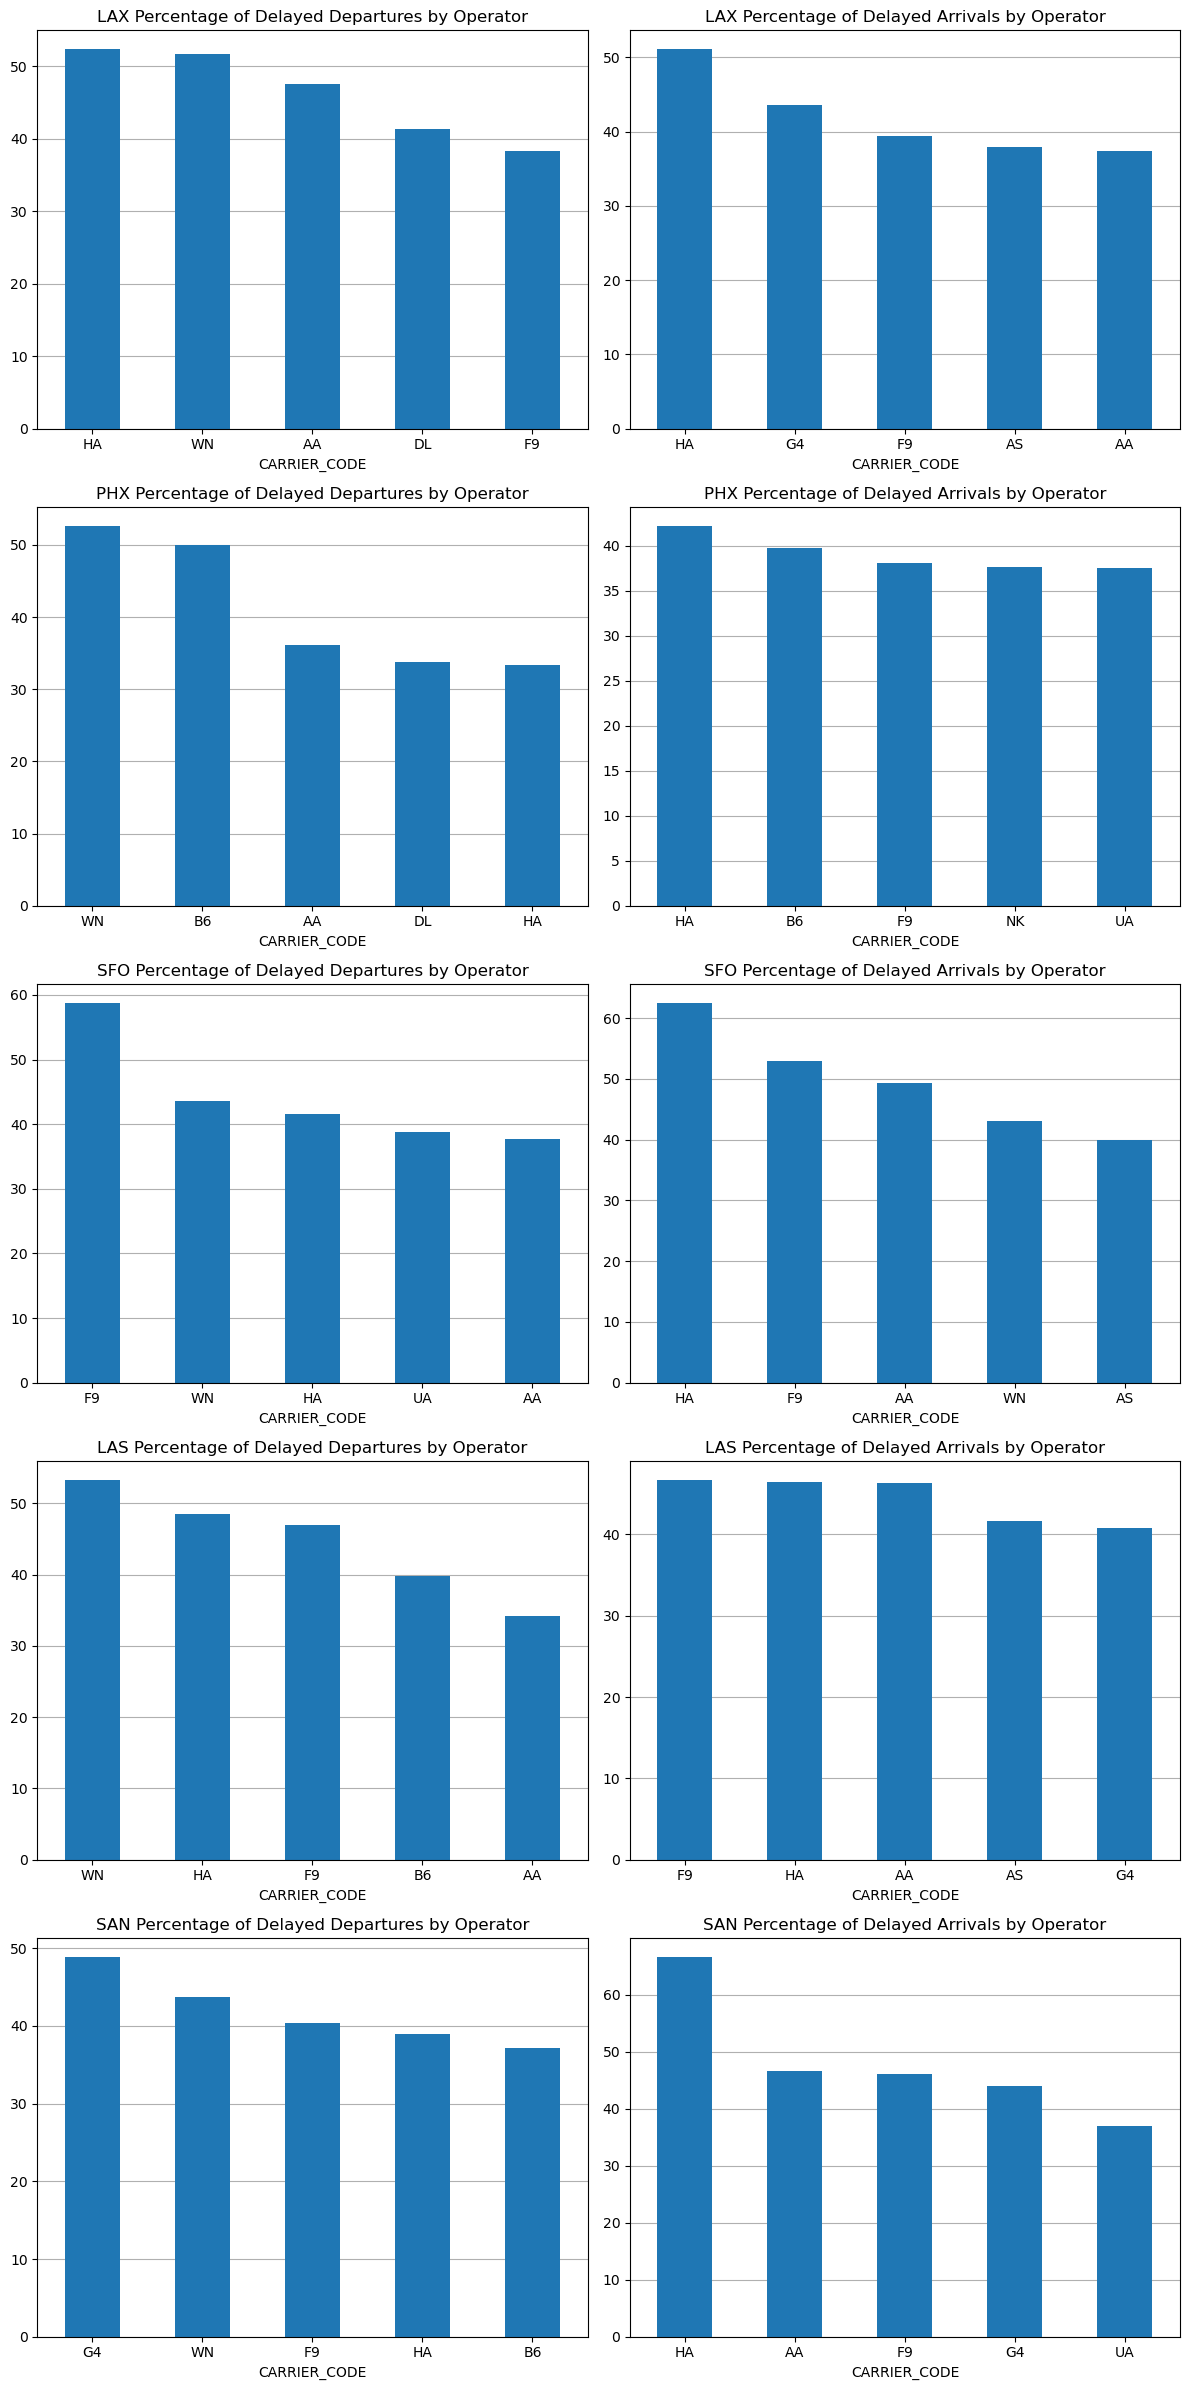

In [26]:
# 2. Create a list of the most common airports, filter data on these
major_airports = flight_df['ORIGIN'].value_counts().head().index.tolist()
orig_dep_delays = orig_dep_delays[orig_dep_delays['ORIGIN'].isin(major_airports)]
dest_arr_delays = dest_arr_delays[dest_arr_delays['DEST'].isin(major_airports)]

# Create the plot of the percentages for each airport
plt.figure(figsize=(12, 24))

for i in range(len(major_airports)):
    # plot the departure delays
    plt.subplot(len(major_airports), 2, 2*i + 1)
    dep_data = orig_dep_delays[orig_dep_delays['ORIGIN'] == major_airports[i]].head()
    dep_data.plot(kind='bar', x='CARRIER_CODE', y='DELAY_PROP', rot=0, zorder=2,
                  title=f"{major_airports[i]} Percentage of Delayed Departures by Operator", 
                  ax=plt.gca(), legend=False)
    plt.grid(axis='y')
    
    # plot the arrival delays
    plt.subplot(len(major_airports), 2, 2*i + 2)
    arr_data = dest_arr_delays[dest_arr_delays['DEST'] == major_airports[i]].head()
    arr_data.plot(kind='bar', x='CARRIER_CODE', y='DELAY_PROP', rot=0, zorder=2,
                  title=f"{major_airports[i]} Percentage of Delayed Arrivals by Operator", 
                  ax=plt.gca(), legend=False)
    plt.grid(axis='y')

plt.tight_layout()
plt.show()

2. Some of the most common airports in this analysis were Los Angeles (LAX), Phoenix (PHX), San Francisco (SFO), Las Vegas (LAS), and San Diego (SAN), thus, these were the airports that were examined more thoroughly for delays. Instantly, some patterns arise that we had been expecting. That is, Hawaiian Airlines (HA) makes the list for the worst departure and arrival delay percentages at every airport. Hawaiian's departure delays ranged from 34-53%, while arrivals fell between 43-66%. Furthermore, for arrivals delays, Hawaiian is the worst airline at 4 of 5 top airports, second only to Frontier Airlines (F9) at Las Vegas (LAS). Speaking of Frontier Airlines, they were present as well in the top five worst delay percentages in all plots except PHX departures, once more following the findings from above. 

    For the rest of the departure delay percentages, Southwest Airlines (WN), American Airlines (AA), JetBlue Airways (B6), and Allegiant Air (G4) were all commonly found. As for the rest of the arrival delay percentages, the delayed operators remained similar, though Southwest Airlines was present in just one of the delay plots, and JetBlue was rarely seen as well. Rather, these positions seemed to be taken by Alaska Airlines (AS). 

## Question 5 — (30 points)

1. Evaluate which airlines have the best record. Display the top 10.

2. For each airline, ensure that you calculate their total flight hours for each month. Explain and visualize the results for the top 10 airlines. 

Hint: the total flight hours is not equivalent to the frequency of flights, and ensure that you display the total hours and not the total minutes.

CARRIER_CODE
YX    74.68
OO    74.40
EV    73.40
YV    70.85
NK    69.49
AS    67.89
G4    67.47
UA    66.40
B6    65.83
DL    64.84
dtype: float64


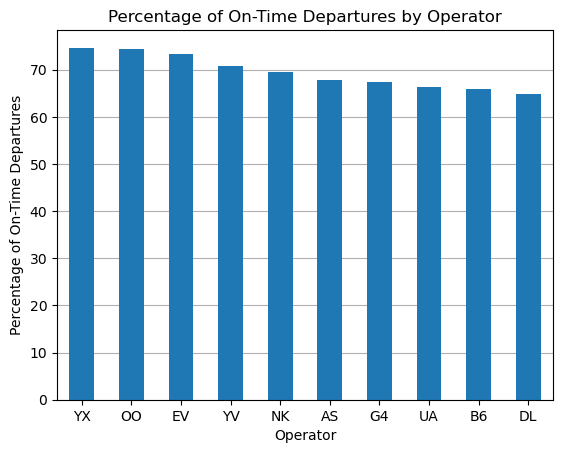

In [27]:
# 1. Find the operators with the best records for on-time departures
best_dep_rec = (100 * flight_df[flight_df['DEP_DELAY'] <= pd.Timedelta(0)]
                .groupby('CARRIER_CODE').size() / flight_df.groupby('CARRIER_CODE')
                .size()).sort_values(ascending=False)
print(round(best_dep_rec[:10], 2))

best_dep_rec[:10].plot(kind='bar', title='Percentage of On-Time Departures by Operator',
                       xlabel='Operator', ylabel='Percentage of On-Time Departures', 
                       rot=0, zorder=2)
plt.grid(axis='y')

CARRIER_CODE
YX    72.73
OO    69.70
EV    69.15
NK    68.14
DL    68.08
B6    66.74
YV    65.44
MQ    65.37
WN    64.93
UA    64.57
dtype: float64


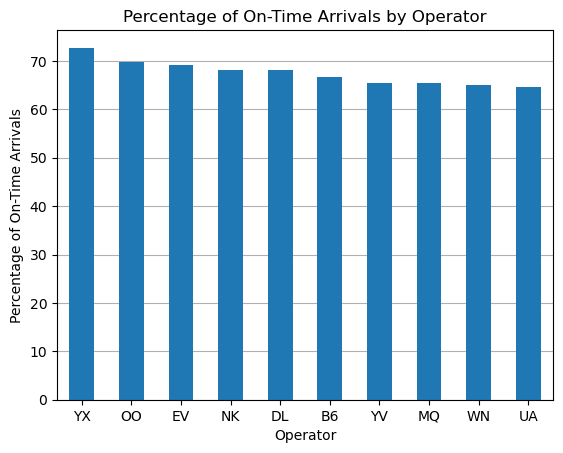

In [28]:
# 1. Find the operators with the best records for on-time arrivals
best_arr_rec = (100 * flight_df[flight_df['ARR_DELAY'] <= pd.Timedelta(0)]
                .groupby('CARRIER_CODE').size() / flight_df.groupby('CARRIER_CODE')
                .size()).sort_values(ascending=False)
print(round(best_arr_rec[:10], 2))

best_arr_rec[:10].plot(kind='bar', title='Percentage of On-Time Arrivals by Operator',
                       xlabel='Operator', ylabel='Percentage of On-Time Arrivals', rot=0,
                       zorder=2)
plt.grid(axis='y')

1. When determining the airlines with the greatest overall likelihood to by on-time, there are a few interesting things to notice. First, the top three operators for on-time departures are also the top three operators for on-time arrivals, but this pattern breaks for the rest of the top 10 most punctual operators. The operator with the greatest percentage of on-time flights is Republic Airways (YX), with 74.68% and 72.73% (-1.95% change) on-time departures and arrivals respectively, which operates flights for Delta Connection, United Express, and American Eagle. The second most punctual operator is SkyWest Airlines (OO), with 74.40% on-time departures and 69.70% on-time arrivals (-4.70%). Once more, SkyWest operates flights for American Eagle, Delta Connection, United Express, and Alaska Airlines. The third most punctual operator was ExpressJet Airlines (EV), which at the time operated for American Eagle (until Jan 5, 2019), United Express, and Delta Connection. ExpressJet had an on-time departure rate of 73.40% and 69.15% for arrivals (-4.26%). 

    The rest of the operators (in order) with the greatest percentage of on-time departures include Mesa Airlines (YV, 70.85%), Spirit Airlines (NK, 69.49%), Alaska Airlines (AS, 67.89%), Allegiant Air (G4, 67.47%), United Airlines (UA, 66.40%), JetBlue Airways (B6, 65.83%), and Delta Air Lines (DL, 64.84%). As for the operators (in order) with the greatest percentage of on-time arrivals, these include Spirit Airlines (NK, 68.14, -1.35%), Delta Air Lines (DL, 68.08%, +3.23%), JetBlue Airways (B6, 66.74%, +0.90%), Mesa Airlines (YV, 65.44%, -5.41%), Envoy Air (MQ, 65.37%, +0.62%) which operates for American Eagle, Southwest Airlines (WN, 64.93%, +12.93%), and United Airlines (UA, 64.57%, -1.83%)
       
    It is interesting to note that on-time departures do not necessarily relate with on-time arrivals, which may be due to longer taxiing times and other airport congestion once a plane departs the gate, or additionally air traffic control delays. Another interesting takeaway is that the top three most punctual operators are all operators for major airlines and not the major airlines themselves. This may be due to the fact that these operators focus only on executing the flights while the main airlines handle the other operational aspects of an airline.

In [29]:
# 2. Find the airlines with the overall most flight time
top_10_hrs_idx = (flight_df.groupby('CARRIER_CODE')['ELAPSED_TIME']
              .sum().sort_values(ascending=False)[:10].index)

# 2. Calculate the total flight hours per month of the top 10 operators
print(round(flight_df[flight_df['CARRIER_CODE'].isin(top_10_hrs_idx)]
      .groupby(flight_df['FL_DATE'].dt.month)['ELAPSED_TIME'].sum()
      / pd.Timedelta(1, 'H'), 2))

FL_DATE
1     421587.25
2     381860.10
3     449138.98
4     434255.55
5     449322.88
6     449463.80
7     468162.95
8     469743.28
9     421621.50
10    447709.50
11    426034.35
12    454450.05
Name: ELAPSED_TIME, dtype: float64


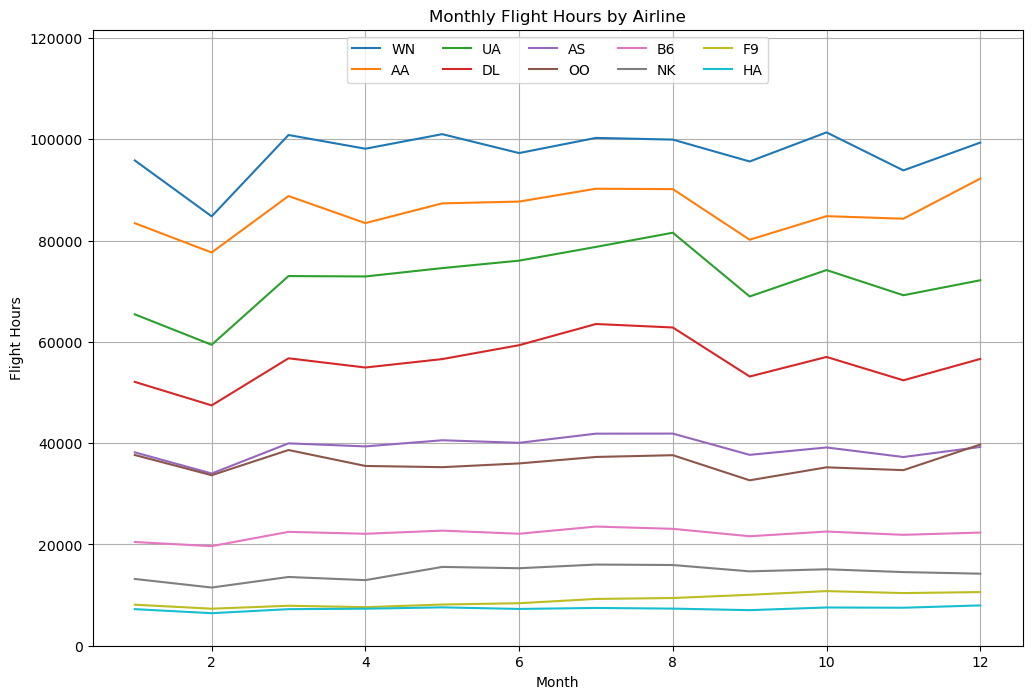

In [30]:
# 2. Find the total flight hours for each month by airline
month_hrs = (flight_df.groupby(['CARRIER_CODE', flight_df['FL_DATE'].dt.month]
                                )['ELAPSED_TIME'].sum().astype('timedelta64[ns]')
              ) / pd.Timedelta(1, 'H')

# 2. Plot the monthly flight hours by airline
plt.style.use('default')
plt.figure(figsize=(12, 8))

for airline in top_10_hrs_idx:
    plt.plot(month_hrs[airline, :], label=airline)
    
plt.title('Monthly Flight Hours by Airline')
plt.legend(loc='upper center', ncols=5)
plt.xlabel('Month')
plt.ylabel('Flight Hours')
plt.ylim((0, 1.2 * month_hrs.max()))
plt.grid()
plt.show()

2. By plotting the top 10 operators with the greatest number of flight hours, a few patterns become evident. First, the operators tend to follow an order, meaning that if one operator has more flight hours one month, another operator does not have more flight hours in a different month. The only place this pattern is broken is between SkyWest Airlines and Alaska Airlines in December, otherwise the rankings remain the same. It can also be determined that the lowest number of flight hours occurs in February (382,000 hours among the top 10 operators), with dips also occurring in September and November. There are upward spikes in March, October, and December, presumably travel for spring break, winter holidays, and other vacation times. Overall the summer months, between June and August, see greater amounts of flight hours. The month with the greatest number of flight hours among these 10 operators is August, with 470,000 hours. 

## Question 6 — (20 points)

1. Select any (3) aircraft, and explore the data to determine where it often travels. Calculate its average arrival and departure delays at the airports. After which analyze all the results to identify any patterns that are evident and also indicate which airline operates that aircraft. Explain your findings and visualize the results.

Note: the TAIL_NUM can help you to identify each unique aircraft.

In [31]:
# 1. Find the top three aircraft from the top three operators
reg_frequency = (flight_df.groupby(['CARRIER_CODE', 'TAIL_NUM'])['TAIL_NUM']
                 .size().sort_values(ascending=False))

# assign variables to the registrations of the aircraft
reg_1 = reg_frequency[operator_props[:3].index[0]].index[0]
reg_2 = reg_frequency[operator_props[:3].index[1]].index[0]
reg_3 = reg_frequency[operator_props[:3].index[2]].index[0]

In [32]:
def convert_mins(time):
    ''' given a time in minutes as a decimal, convert the time to the 
        format of M:SS
    '''
    mins = int(time // 1)
    secs = str(round((time - mins) * 60)).zfill(2)
    
    if secs == '60':
        mins += 1
        secs = '00'
    
    return f"{mins}:{secs}"

In [33]:
def location_stats(registration, aircraft_df, loc_type):
    ''' given a registration, aircraft data frame and a location 
        type (DEP or ARR), return statistics about the aircraft as a tuple
    '''
    # create dictionary based on type
    loc_dct = {'DEP' : {'LOC' : 'ORIGIN', 'DELAY' : 'DEP_DELAY'},
               'ARR' : {'LOC' : 'DEST', 'DELAY' : 'ARR_DELAY'}}
    
    # create data frame for aircraft's delayed departures
    delay_df = aircraft_df[aircraft_df[loc_dct[loc_type]['DELAY']] > pd.Timedelta(0)]
    num_delay = delay_df.shape[0]
    avg_delay = (delay_df[loc_dct[loc_type]['DELAY']].sum() / pd.Timedelta(1, 'm') 
                 / aircraft_df.shape[0])
    
    # create a grouping of the average delay by location type
    avgs = ((flight_df[flight_df['TAIL_NUM'] == registration]
                        .groupby(loc_dct[loc_type]['LOC'])[loc_dct[loc_type]['DELAY']].sum() 
                        / flight_df[flight_df['TAIL_NUM'] == registration]
                        .groupby(loc_dct[loc_type]['LOC']).size())
                        .sort_values(ascending=False).round('s') / pd.Timedelta(1, 'm'))
    avgs = avgs[avgs.notnull()]
    
    return (delay_df, num_delay, avg_delay, avgs)

In [34]:
def aircraft_stats(registration, airline):
    ''' given a registration, return statistics about the aircraft such as
        the most frequent locations, delays, and additional patterns
    '''
    # create data frame for all of aircraft's flights
    aircraft_df = flight_df.loc[flight_df['TAIL_NUM'] == registration]
    num_flights = aircraft_df.shape[0]
    top_5_dest = aircraft_df['DEST'].value_counts().head() 
    
    # get statistics for departures and arrivals
    dep_stats = location_stats(registration, aircraft_df, 'DEP')
    arr_stats = location_stats(registration, aircraft_df, 'ARR')
    
    # print the summary
    print(f"Aircraft - {registration}\nAirline - {airline}\n\n"
          f"Num Flights - {num_flights}\n\n"
          f"Num Delayed Departures - {dep_stats[1]}\n"
          f"Pct Delayed Departures - {round(100 * dep_stats[1] / num_flights, 2)}%\n"
          f"Avg Departure Delay - {convert_mins(dep_stats[2])} mins\n\n"
          f"Num Delayed Arrivals - {arr_stats[1]}\n"
          f"Pct Delayed Arrivals - {round(100 * arr_stats[1] / num_flights, 2)}%\n"
          f"Avg Arrival Delay - {convert_mins(arr_stats[2])} mins\n")
    
    # create plots
    top_5_dest.plot(kind='bar', title=f"Most Common Airports for {registration}",
                    xlabel='Airport', ylabel='Frequency', rot=0, zorder=2)
    print(top_5_dest)
    plt.grid(axis='y')
    
    print(f"{registration} Worst Average Departure Delays by Airport\n"
          f"{round(dep_stats[3].head(), 2)}\n")
    print(f"{registration} Worst Average Arrival Delays by Airport\n"
          f"{round(arr_stats[3].head(), 2)}\n")
    print(f"{registration} Best Average Departure Delays by Airport\n"
          f"{round(dep_stats[3].tail()[::-1], 2)}\n")
    print(f"{registration} Best Average Arrival Delays by Airport\n"
          f"{round(arr_stats[3].tail()[::-1], 2)}")

Aircraft - N7875A
Airline - WN

Num Flights - 1067

Num Delayed Departures - 499
Pct Delayed Departures - 46.77%
Avg Departure Delay - 11:30 mins

Num Delayed Arrivals - 381
Pct Delayed Arrivals - 35.71%
Avg Arrival Delay - 9:41 mins

LAS    132
PHX    115
OAK     85
SAN     80
LAX     76
Name: DEST, dtype: int64
N7875A Worst Average Departure Delays by Airport
ORIGIN
MSY    112.50
CLE     35.00
MCI     28.25
SNA     23.75
LGB     23.13
dtype: float64

N7875A Worst Average Arrival Delays by Airport
DEST
BHM    52.50
BUF    50.00
TUL    39.50
IND    36.33
STL    22.67
dtype: float64

N7875A Best Average Departure Delays by Airport
ORIGIN
MCO    0.0
MAF    0.0
OKC    0.0
IND    0.0
DTW    0.0
dtype: float64

N7875A Best Average Arrival Delays by Airport
DEST
BWI    0.0
DTW    0.0
LIT    0.0
MAF    0.0
AMA    0.0
dtype: float64


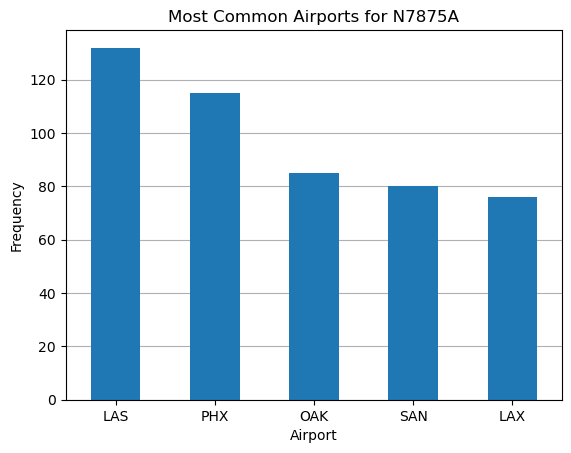

In [35]:
# 1. Print the summary statistics for the first aircraft  
aircraft_stats(reg_1, operator_props[:3].index[0])

1. Although there was a choice to choose any three aircraft at random, we wanted to ensure that there would be enough flights for the aircraft that we choose to have an interesting analysis, thus, we choose the top aircraft from each of the top operators by flight volume: Southwest Airlines (WN), American Airlines (AA), and United Airlines (UA). For Southwest, the aircraft that was chosen, N7875A, is a Boeing 737-7Q8, a mid-sized plane usually used for longer or more densely packed regional flights. Throughout the course of a year, the aircraft flew 1067 flights to or from locations in CA, NV, or AZ, an average of 2.92 daily, and had departure delays on 499 of them (46.77% of all flights), with an average departure delay of 11.5 minutes. However, the aircraft often made-up time in the sky, as it only had 381 arrival delays (35.71%), with an average arrival delay of 9:41 minutes. N7875A most often traveled to Las Vegas (LAS) with 132 flights, but had a higher portion of flights to Phoenix (PHX) as well with 115. Flights to Oakland (OAK), San Diego (SAN), and Los Angeles (LAX) all fell between 75-85 flights. 

    The airports at which N7875A has the longest departure delays are New Orleans (MSY) with 112.5 minutes on average, Cleveland (CLE) at 35 minutes, and Kansas City (MCI) with 28.25 minutes. The worst arrival airports are Birmingham (BHM) at 52.5 minutes, Buffalo (BUF) at 50 minutes, and Tulsa (TUL) with an average delay of 39.5 minutes. On the other end of the spectrum, the best airports for departures were Orlando (MCO), Midland (MAF), and Oklahoma City (OKC), all with average departure delays of 0 minutes. As for the arrival airports with the best average delays, these include Baltimore (BWI), Detroit (DTW), and Little Rock (LIT), again with average delays of 0 minutes!

Aircraft - N130AN
Airline - AA

Num Flights - 957

Num Delayed Departures - 348
Pct Delayed Departures - 36.36%
Avg Departure Delay - 12:00 mins

Num Delayed Arrivals - 308
Pct Delayed Arrivals - 32.18%
Avg Arrival Delay - 11:46 mins

LAX    471
HNL    100
ORD     83
DFW     65
OGG     55
Name: DEST, dtype: int64
N130AN Worst Average Departure Delays by Airport
ORIGIN
DCA    289.33
PHX     37.17
SFO     18.72
HNL     15.83
ORD     15.68
dtype: float64

N130AN Worst Average Arrival Delays by Airport
DEST
SMF    216.00
PHX     35.33
CLT     28.50
SFO     20.72
LAS     14.98
dtype: float64

N130AN Best Average Departure Delays by Airport
ORIGIN
SMF    0.00
AUS    0.00
MCO    2.28
KOA    3.72
OGG    4.43
dtype: float64

N130AN Best Average Arrival Delays by Airport
DEST
DCA    0.00
PHL    0.00
BOS    3.77
DFW    3.88
MCO    4.85
dtype: float64


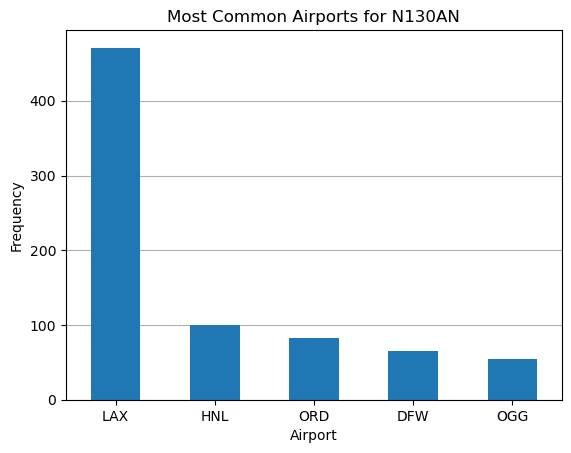

In [36]:
# 1. Print the summary statistics for the second aircraft
aircraft_stats(reg_2, operator_props[:3].index[1])

1. The next aircraft in this last part of the analysis was N130AN, an American Airlines Airbus a321-231, the European competitor to America's larger Boeing 737 variants. In comparison to the Southwest aircraft, N130AN was based in a much more specific location, which is visualized in the plot. Over the course of the year, the aircraft flew 957 flights, or about 2.62 daily, of which 348 departures (36.36%) were delayed, and 308 arrivals were delayed (32.18%). The average departure delay was 12 minutes, while the average arrival delay was a bit shorter, at 11:46 minutes. Both delays are longer than Southwest Airlines' most frequently used aircraft. Something that was interesting, however, was that N130AN was clearly focused around Los Angeles (LAX), as it flew here 471 times over the course of the year, nearly 5 times the second most common airport, Honolulu (HNL), where the aircraft flew just 100 times. The third most common airport was Chicago (ORD), with 83 flights, followed by Dallas (DFW) and Kahului (OGG), which had 65 and 55 flights respectively. 

    Taking a closer look into the statistics from various airports, N130AN had the worst luck departing from Washington D.C. (DCA), where the average departure delay was 289.33 minutes. Phoenix (PHX) was second, with an average delay of 37.17 minutes, followed by San Francisco (SFO), where the average departure delay was 15.83 minutes. For the worst arrivals, Sacramento (SMF) took first place, with an average arrival delay of 216 minutes. Phoenix (PHX) again made the list, with an average of 35.33 minutes, while Charlotte (CLT) was in third place, with an average arrival delay of 28.5 minutes. As for the airports with the shortest delays, Sacramento and Austin (AUS) had the best average departure delay, 0 minutes, while Orlando had an average departure delay of 2.28 minutes. As for arrival delays, Washington D.C. and Philadelphia (PHL) had the shortest average delays, both 0 minutes, while Boston (BOS) had an average of 3.77 minutes. For N130AN, it was particularly interesting to notice that the two airports with the worst departure and arrival delays were the best for the opposite categories (i.e. DCA had the longest departure delay but shortest arrival, and vice versa for SMF).

Aircraft - N77525
Airline - UA

Num Flights - 799

Num Delayed Departures - 191
Pct Delayed Departures - 23.9%
Avg Departure Delay - 10:18 mins

Num Delayed Arrivals - 232
Pct Delayed Arrivals - 29.04%
Avg Arrival Delay - 11:02 mins

SFO    213
LAX    131
OGG     51
DEN     48
SNA     48
Name: DEST, dtype: int64
N77525 Worst Average Departure Delays by Airport
ORIGIN
SEA    28.08
SAN    27.42
EWR    24.00
IAH    23.92
SNA    19.78
dtype: float64

N77525 Worst Average Arrival Delays by Airport
DEST
SEA    33.60
RNO    33.20
MCO    33.00
SJC    33.00
AUS    22.63
dtype: float64

N77525 Best Average Departure Delays by Airport
ORIGIN
MCO    0.0
ONT    0.0
MCI    0.0
HNL    0.0
PIT    0.0
dtype: float64

N77525 Best Average Arrival Delays by Airport
DEST
SLC    0.0
BNA    0.0
BWI    0.0
MCI    0.0
CVG    0.0
dtype: float64


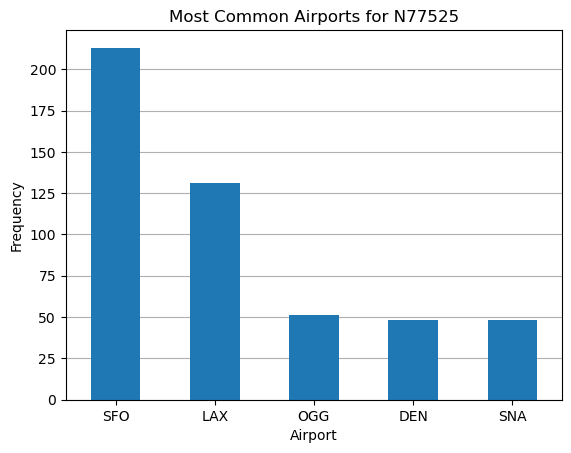

In [37]:
# 1. Print the summary statistics for the third aircraft
aircraft_stats(reg_3, operator_props[:3].index[2])

1. For the final aircraft in this analysis, we took a look at United Airlines' N77525, a Boeing 737-824. Throughout the year, this aircraft flew 799 flights to or from CA, AZ, or NV, for an average of 2.13, making this aircraft the least traveled of the three. Of those 799 flights, 191 (23.9%) were delayed at departure, while 232 (29.04%) were delayed upon arrival, making this the only aircraft of the three to have more arrival delays than departure delays. Further, the average departure delay was 10:18 minutes, while the average arrival delay was 11:02 minutes. Something that was interesting to notice was that this aircraft had greater focus on two airports, compared to the Southwest aircraft which had more equal percentages, and the American aircraft which had one airport that dominated the rest. In the case of N77525, its most common airport was San Francisco (SFO) where it flew 213 times, followed by Los Angeles (LAX), where it flew 131 times. The other airports, Kahului (OGG), Denver (DEN), and Orange County (SNA), all had around 50 flights.

    Taking a closer look at the airports with the worst average departure delays, Seattle-Tacoma (SEA) tops the list, with an average delay of 28.08 minutes, followed by San Diego (SAN) at 27.42 minutes, and Newark (EWR) with an average departure delay of 24 minutes. Seattle-Tacoma (SEA) was also the airport with the worst arrival delays for N77525, with an average of 33.6 minutes. This was followed closely by Reno (RNO) and Orlando (MCO), whose average arrival delays were 33.2 and 33 minutes respectively. As for the airports with the shortest average departure delays, these include Orlando (MCO), Ontario (ONT), and Kansas City (MCI), which all had average departure delays of 0 minutes. The same was true for Salt Lake City (SLC), Nashville (BNA), and Baltimore (BNA) arrivals, as these three airports had average arrival delays of 0 minutes.